In [1]:
!pip3 install fast-tabnet

In [2]:
from fastai2.basics import *
from fastai2.tabular.all import *
from fast_tabnet.core import *

In [3]:
BATCH_SIZE = 1024 
EPOCHS = 150
LR = 0.02
seed = 2020   # seed for reproducible results
patience = 50
device = torch.device('cuda')
FOLDS = 5
fold = 0

In [4]:
# Defining Categorical variables and their Indexes, embedding dimensions , number of classes each have
df = pd.read_csv('/data/full/folds_13062020.csv')
df.head()

,image_id,patient_id,target,source,sex,age_approx,anatom_site_general_challenge,stratify_group,fold
0,ISIC_2637011,IP_7279968,0,ISIC20,male,45.0,head/neck,31,0
1,ISIC_0015719,IP_3075186,0,ISIC20,female,45.0,upper extremity,7,2
2,ISIC_0052212,IP_2842074,0,ISIC20,female,50.0,lower extremity,5,4
3,ISIC_0068279,IP_6890425,0,ISIC20,female,45.0,head/neck,7,0
4,ISIC_0074268,IP_8723313,0,ISIC20,female,55.0,upper extremity,6,4


In [5]:
df_test =pd.read_csv('/data/full/test.csv')

In [6]:
cat_names = ['sex', 'anatom_site_general_challenge']
cont_names = ['age_approx']
procs = [Categorify, FillMissing, Normalize]
y_names = 'target'
splits = (L(df[df.fold != fold].index.tolist()), L(df[df.fold == fold].index.tolist()))

In [7]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names, y_block=CategoryBlock(), splits=splits)

In [8]:
dls = to.dataloaders()
dls.valid.show_batch()

,sex,anatom_site_general_challenge,age_approx,target
0,male,head/neck,45.000000,0
1,female,head/neck,45.000000,0
2,male,lower extremity,25.000001,0
3,female,lower extremity,50.000000,0
4,female,torso,55.000000,0
5,male,torso,45.000000,0
6,male,torso,45.000000,0
7,female,unknown,30.000000,0
8,male,head/neck,45.000000,0
9,male,torso,65.000000,0


In [9]:
to_tst = to.new(df_test)
to_tst.process()
to_tst.all_cols.head()

,sex,anatom_site_general_challenge,age_approx
0,2,0,1.160915
1,2,3,-0.692332
2,1,6,0.234291
3,1,6,-0.074583
4,1,3,-0.383458


In [10]:
emb_szs = get_emb_sz(to); print(emb_szs)

[(4, 3), (9, 5)]


In [11]:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=32, n_a=32, n_steps=4); 

In [12]:
from sklearn.metrics import roc_auc_score
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

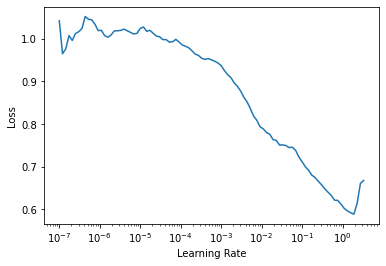

In [13]:
lr, lr_step = learn.lr_find()

In [14]:
lr, lr_step

(0.19054607152938843, 0.005248074419796467)

In [ ]:
learn.fit_one_cycle(30, lr, cbs=EarlyStoppingCallback(monitor='valid_loss', patience=3))

epoch,train_loss,valid_loss,accuracy,time
0,0.286723,0.304130,0.908424,00:29


In [ ]:
learn.show_results()

In [ ]:
test_dl = dls.test_dl(df_test, shuffle=False)

In [ ]:
preds, targs, logits = learn.get_preds(dl=test_dl, reorder=False, with_decoded=True)

In [ ]:
preds[:10]